In [1]:
import numpy as np
import numba
import matplotlib.pyplot as plt
from scipy.spatial.distance import hamming
from time import time
import arviz

#Import the helper functions and the Tabu sampling implementation
from IBCSampler import *
from IBCHelp import *
from GelmanRubinDiagnostic import *

#Autocorrelation function as implemented by Power and Goldman
@numba.njit()
def autocorr(x, lags):
    mean=np.mean(x)
    var=np.var(x)
    xp=x-mean
    corr=[1. if l==0 else np.sum(xp[l:]*xp[:-l])/len(x)/var for l in lags]
    return np.array(corr)

In [2]:
#The main parameters
dim = int(1e3) #dimensionality of the state space
pvals = np.random.uniform(size=dim) #random p_vec test
N = int(1e5) #sampling size
starting_state = np.ones(dim) #starting state
baseline_state = np.ones(dim) #The comparison states for the plots

#Time and thin rate for the Zanella sampler
T_z = 1500
thin_rate_z = 0.0150

#Time and thin rate for the Tabu sampler
T_t = 3000
thin_rate_t = 0.03


#Sampling a random starting state
starting_state = np.random.randint(0, 2, dim)

#Defining the Barker balancing function
g = lambda t: t/(1+t) #optimal balancing funtion

In [3]:
#Running the random walk sampler
trace_rw, energy_rw, hamming_rw, accepted_rw, runtime_rw = rw_sampler(dim, N, pvals, starting_state, baseline_state)

#Running the pointwise informed proposal sampler
trace_pw, energy_pw, hamming_pw, accepted_pw, runtime_pw = pw_sampler(dim, N, pvals, g, starting_state, baseline_state)

#Running the Zanella sampler
trace_z, energy_z, hamming_z, iter_z, runtime_z = zanella_sampler(dim, T_z, thin_rate_z, pvals, g, starting_state, baseline_state)

#Running the Tabu sampler
trace_t, energy_t, hamming_t, alpha, iter_t, runtime_t = tabu_sampler(dim, T_t, thin_rate_t, pvals, g, starting_state, baseline_state)

Percent: [--------------------------------------->] 100%
Acceptance ratio:  0.4958
Runtime:  9.59
Percent: [--------------------------------------->] 100%
Acceptance ratio:  0.7494
Runtime:  12.85
Percent: [--------------------------------------->] 100%Runtime:  36.92
Percent: [--------------------------------------->] 100%Average excursion length:  33.0
Runtime:  48.34


In [4]:
#The effective sample sizes of the Hamming distance
ESS_hamming_rw = arviz.ess(hamming_rw)/runtime_rw
ESS_hamming_pw = arviz.ess(hamming_pw)/runtime_pw
ESS_hamming_t = arviz.ess(hamming_z)/runtime_t
ESS_hamming_z = arviz.ess(hamming_t)/runtime_z

#The effective sample size of the log energy of the target density
ESS_energy_rw = arviz.ess(energy_rw)/runtime_rw
ESS_energy_pw = arviz.ess(energy_pw)/runtime_pw
ESS_energy_t = arviz.ess(energy_z)/runtime_t
ESS_energy_z = arviz.ess(energy_t)/runtime_z

#The acceptance ratios
acc_ratio_rw = accepted_rw/N
acc_ratio_pw = accepted_pw/N

#The mean reversion
mean_reversion = 33.0

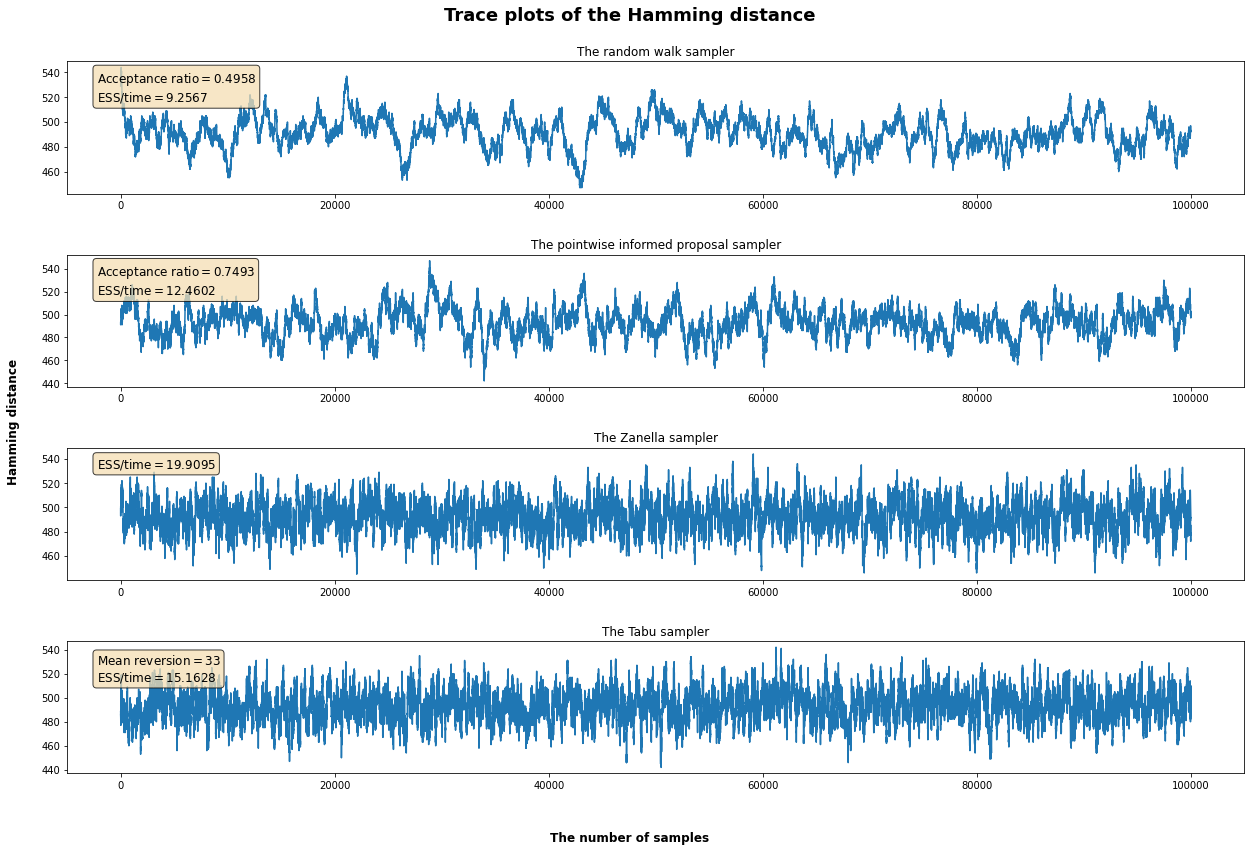

In [5]:
#Trace plots of the Hamming distance relative to the state with only ones
fig, ax = plt.subplots(4, 1, figsize=(18,12))
fig.suptitle("Trace plots of the Hamming distance", fontsize=18, fontweight="bold")
fig.supylabel("Hamming distance", fontweight="bold")
fig.supxlabel("The number of samples", fontweight="bold")
fig.tight_layout(h_pad=4, pad=2.5)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.75)

#The random walk subplot
ax[0].plot(hamming_rw)
ax[0].set_title("The random walk sampler")

#Adding a textbox
str_rw = '\n'.join((
    r'$\mathrm{Acceptance \ ratio}=%.4f$' % (acc_ratio_rw, ),
    r'$\mathrm{ESS/time}=%.4f$' % (ESS_hamming_rw, )))

ax[0].text(0.025, 0.7, str_rw,  fontsize=12, bbox=props, transform=ax[0].transAxes)

#The pointwise subplot
ax[1].plot(hamming_pw)
ax[1].set_title("The pointwise informed proposal sampler")

#Adding a textbox
str_pw = '\n'.join((
    r'$\mathrm{Acceptance \ ratio}=%.4f$' % (acc_ratio_pw, ),
    r'$\mathrm{ESS/time}=%.4f$' % (ESS_hamming_pw, )))

ax[1].text(0.025, 0.7, str_pw,  fontsize=12, bbox=props, transform=ax[1].transAxes)

#The Zanella sampler
ax[2].plot(hamming_z)
ax[2].set_title("The Zanella sampler")

#Adding a textbox
str_z = r'$\mathrm{ESS/time}=%.4f$' % (ESS_hamming_z, )


ax[2].text(0.025, 0.85, str_z,  fontsize=12, bbox=props, transform=ax[2].transAxes)

ax[3].plot(hamming_t)
ax[3].set_title("The Tabu sampler")

#Adding a textbox
str_t = '\n'.join((
    r'$\mathrm{Mean \ reversion}=%.0f$' % (mean_reversion, ),
    r'$\mathrm{ESS/time}=%.4f$' % (ESS_hamming_t, )))

ax[3].text(0.025, 0.7, str_t,  fontsize=12, bbox=props, transform=ax[3].transAxes)
plt.show()

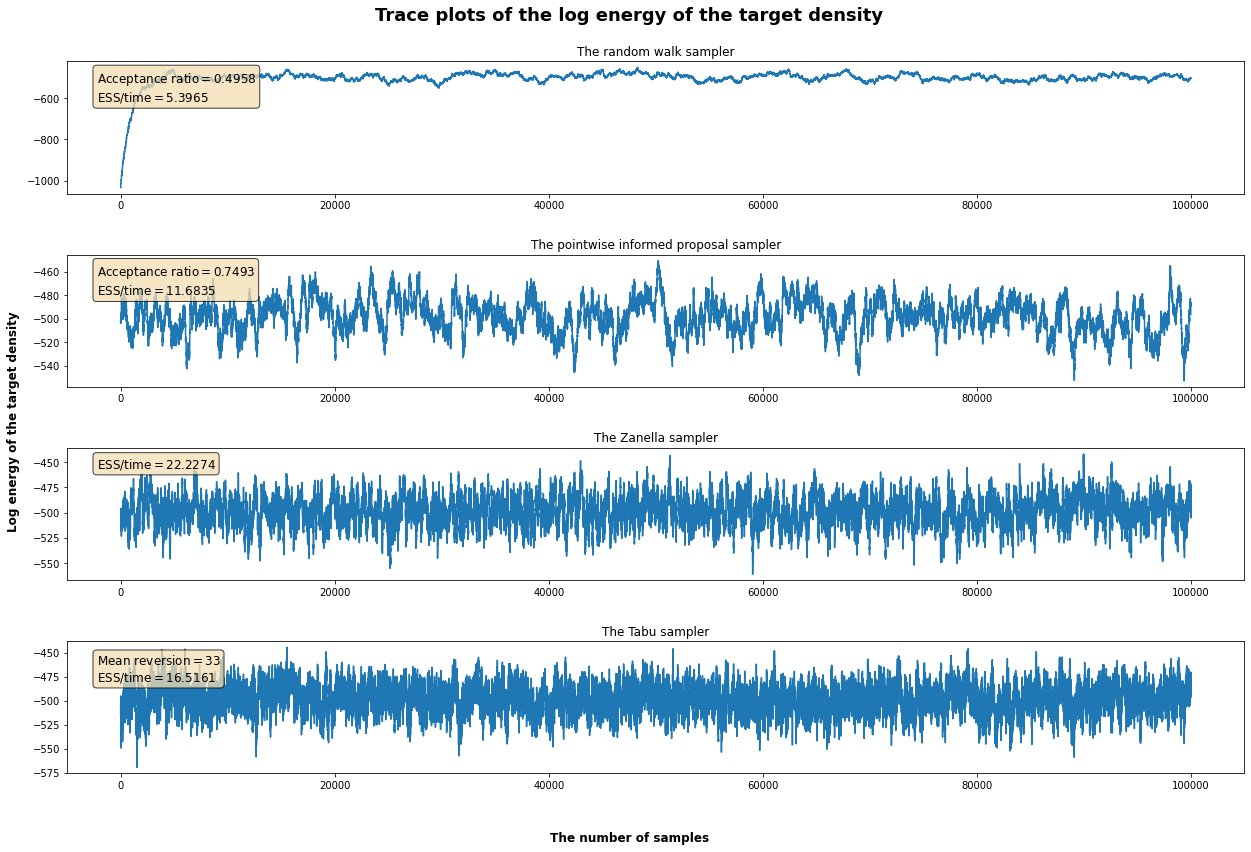

In [6]:
#Traceplots of the log energy of the target distribution
fig, ax = plt.subplots(4, 1, figsize=(18,12))
fig.suptitle("Trace plots of the log energy of the target density", fontsize=18, fontweight="bold")
fig.supylabel("Log energy of the target density", fontweight="bold")
fig.supxlabel("The number of samples", fontweight="bold")
fig.tight_layout(h_pad=4, pad=2.5)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.75)

#The random walk subplot
ax[0].plot(energy_rw)
ax[0].set_title("The random walk sampler")

#Adding a textbox
str_rw = '\n'.join((
    r'$\mathrm{Acceptance \ ratio}=%.4f$' % (acc_ratio_rw, ),
    r'$\mathrm{ESS/time}=%.4f$' % (ESS_energy_rw, )))

ax[0].text(0.025, 0.7, str_rw,  fontsize=12, bbox=props, transform=ax[0].transAxes)

#The pointwise subplot
ax[1].plot(energy_pw)
ax[1].set_title("The pointwise informed proposal sampler")

#Adding a textbox
str_pw = '\n'.join((
    r'$\mathrm{Acceptance \ ratio}=%.4f$' % (acc_ratio_pw, ),
    r'$\mathrm{ESS/time}=%.4f$' % (ESS_energy_pw, )))

ax[1].text(0.025, 0.7, str_pw,  fontsize=12, bbox=props, transform=ax[1].transAxes)

#The Zanella sampler
ax[2].plot(energy_z)
ax[2].set_title("The Zanella sampler")

#Adding a textbox
str_z = r'$\mathrm{ESS/time}=%.4f$' % (ESS_energy_z, )


ax[2].text(0.025, 0.85, str_z,  fontsize=12, bbox=props, transform=ax[2].transAxes)

ax[3].plot(energy_t)
ax[3].set_title("The Tabu sampler")

#Adding a textbox
str_t = '\n'.join((
    r'$\mathrm{Mean \ reversion}=%.0f$' % (mean_reversion, ),
    r'$\mathrm{ESS/time}=%.4f$' % (ESS_energy_t, )))

ax[3].text(0.025, 0.7, str_t,  fontsize=12, bbox=props, transform=ax[3].transAxes)
plt.show()

In [7]:
#Autocorrelation of the Hamming distance up to 3000 lags
acorr_hamming_rw = autocorr(hamming_rw[int(0.2*N):], np.arange(0, 3000))
acorr_hamming_pw = autocorr(hamming_pw[int(0.2*N):], np.arange(0, 3000))
acorr_hamming_z = autocorr(hamming_z[int(0.2*N):], np.arange(0, 3000))
acorr_hamming_t = autocorr(hamming_t[int(0.2*N):], np.arange(0, 3000))

#Autocorrelation of log energy of the target density up to 3000 lags
acorr_energy_rw = autocorr(energy_rw[int(0.2*N):], np.arange(0, 3000))
acorr_energy_pw = autocorr(energy_pw[int(0.2*N):], np.arange(0, 3000))
acorr_energy_z = autocorr(energy_z[int(0.2*N):], np.arange(0, 3000))
acorr_energy_t = autocorr(energy_t[int(0.2*N):], np.arange(0, 3000))

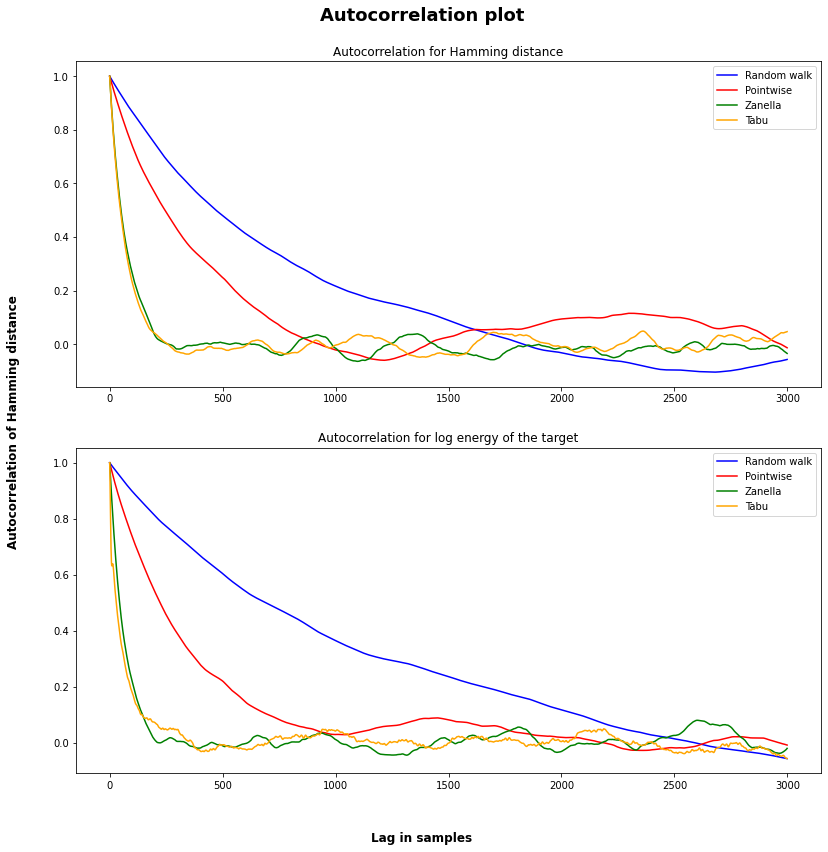

In [8]:
#The autocorrelation plot for the Hamming distance
fig, ax = plt.subplots(2, 1, figsize=(12,12))
fig.suptitle("Autocorrelation plot", fontsize=18, fontweight="bold")
fig.supylabel("Autocorrelation of Hamming distance", fontweight="bold")
fig.supxlabel("Lag in samples", fontweight="bold")
fig.tight_layout(h_pad=4, pad=2.5)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.75)

ax[0].plot(acorr_hamming_rw, label="Random walk", color="blue")
ax[0].plot(acorr_hamming_pw, label="Pointwise", color="red")
ax[0].plot(acorr_hamming_z, label="Zanella", color="green")
ax[0].plot(acorr_hamming_t, label="Tabu", color="orange")
ax[0].set_title("Autocorrelation for Hamming distance")
ax[0].legend()

ax[1].plot(acorr_energy_rw, label="Random walk", color="blue")
ax[1].plot(acorr_energy_pw, label="Pointwise", color="red")
ax[1].plot(acorr_energy_z, label="Zanella", color="green")
ax[1].plot(acorr_energy_t, label="Tabu", color="orange")
ax[1].set_title("Autocorrelation for log energy of the target")
ax[1].legend()




In [9]:
#Running the overdispersed distribution
num_rw = 100
m = 10
N = 1000
N_samples, energy_rate, starting_states = start_sequences(dim, pvals, N, num_rw, m)

In [10]:
#The Gelman-Rubin diagnostic for n=1000 (summary statistic log energy of the target density)
n = int(1e3)
T_z = 15
thin_rate_z = 0.015
T_t = 30
thin_rate_t = 0.03
traces_rw = []
traces_pw = []
traces_z = []
traces_t = []
for i in np.arange(0,m):
    #Run the sampler in this case
    trace_rw, energy_rw, hamming_rw, num_acc_rw, runtime_rw = rw_sampler(dim, 2*n, pvals, starting_states[i,:], baseline_state)
    trace_pw, energy_pw, hamming_pw, num_acc_pw, runtime_pw = pw_sampler(dim, 2*n, pvals, g, starting_states[i,:], baseline_state)
    trace_z, energy_z, hamming_z, iter_z, runtime_z = zanella_sampler(dim, 2*T_z, thin_rate_z, pvals, g, starting_states[i,:], baseline_state)
    trace_t, energy_t, hamming_t, alpha_t, iter_t, runtime_t = tabu_sampler(dim, 2*T_t, thin_rate_t, pvals, g, starting_states[i,:], baseline_state)
    traces_rw.append(hamming_rw)
    traces_pw.append(energy_pw)
    traces_z.append(energy_z)
    traces_t.append(energy_t)
    
R_energy_rw = gelman_rubin(traces_rw, n, m)
R_energy_pw = gelman_rubin(traces_pw, n, m)
R_energy_z = gelman_rubin(traces_z, n, m)
R_energy_t = gelman_rubin(traces_t, n, m)

print("-------------------------------------------------------------------")
print("The scale reduction for the energy of the target_density: ",R_energy_rw)
print("-------------------------------------------------------------------")
print("-------------------------------------------------------------------")
print("The scale reduction for the energy of the target_density: ",R_energy_pw)
print("-------------------------------------------------------------------")
print("-------------------------------------------------------------------")
print("The scale reduction for the energy of the target_density: ",R_energy_z)
print("-------------------------------------------------------------------")
print("-------------------------------------------------------------------")
print("The scale reduction for the energy of the target_density: ",R_energy_t)
print("-------------------------------------------------------------------")

Percent: [--------------------------------------->] 100%
Acceptance ratio:  0.576
Runtime:  0.48
Percent: [--------------------------------------->] 100%
Acceptance ratio:  0.7485
Runtime:  0.35
Percent: [--------------------------------------->] 99%Runtime:  0.95
Percent: [--------------------------------------->] 99%Average excursion length:  33.0
Runtime:  1.0
Percent: [--------------------------------------->] 100%
Acceptance ratio:  0.5715
Runtime:  0.15
Percent: [--------------------------------------->] 100%
Acceptance ratio:  0.7365
Runtime:  0.23
Percent: [--------------------------------------->] 99%Runtime:  0.69
Percent: [--------------------------------------->] 99%Average excursion length:  33.0
Runtime:  0.97
Percent: [--------------------------------------->] 100%
Acceptance ratio:  0.57
Runtime:  0.16
Percent: [--------------------------------------->] 100%
Acceptance ratio:  0.744
Runtime:  0.26
Percent: [--------------------------------------->] 100%Runtime:  0.86
Pe

In [11]:
#The Gelman-Rubin diagnostic for n=5000 (summary statistic log energy of the target density)
n = int(5e3)
T_z = 75
thin_rate_z = 0.015
T_t = 150
thin_rate_t = 0.03
traces_rw = []
traces_pw = []
traces_z = []
traces_t = []
for i in np.arange(0,m):
    #Run the sampler in this case
    trace_rw, energy_rw, hamming_rw, num_acc_rw, runtime_rw = rw_sampler(dim, 2*n, pvals, starting_states[i,:], baseline_state)
    trace_pw, energy_pw, hamming_pw, num_acc_pw, runtime_pw = pw_sampler(dim, 2*n, pvals, g, starting_states[i,:], baseline_state)
    trace_z, energy_z, hamming_z, iter_z, runtime_z = zanella_sampler(dim, 2*T_z, thin_rate_z, pvals, g, starting_states[i,:], baseline_state)
    trace_t, energy_t, hamming_t, alpha_t, iter_t, runtime_t = tabu_sampler(dim, 2*T_t, thin_rate_t, pvals, g, starting_states[i,:], baseline_state)
    traces_rw.append(hamming_rw)
    traces_pw.append(energy_pw)
    traces_z.append(energy_z)
    traces_t.append(energy_t)
    
R_energy_rw = gelman_rubin(traces_rw, n, m)
R_energy_pw = gelman_rubin(traces_pw, n, m)
R_energy_z = gelman_rubin(traces_z, n, m)
R_energy_t = gelman_rubin(traces_t, n, m)

print("-------------------------------------------------------------------")
print("The scale reduction for the energy of the target_density: ",R_energy_rw)
print("-------------------------------------------------------------------")
print("-------------------------------------------------------------------")
print("The scale reduction for the energy of the target_density: ",R_energy_pw)
print("-------------------------------------------------------------------")
print("-------------------------------------------------------------------")
print("The scale reduction for the energy of the target_density: ",R_energy_z)
print("-------------------------------------------------------------------")
print("-------------------------------------------------------------------")
print("The scale reduction for the energy of the target_density: ",R_energy_t)
print("-------------------------------------------------------------------")

Percent: [--------------------------------------->] 100%
Acceptance ratio:  0.5049
Runtime:  0.77
Percent: [--------------------------------------->] 100%
Acceptance ratio:  0.7531
Runtime:  1.15
Percent: [--------------------------------------->] 100%Runtime:  3.82
Percent: [--------------------------------------->] 100%Average excursion length:  33.0
Runtime:  4.43
Percent: [--------------------------------------->] 100%
Acceptance ratio:  0.4924
Runtime:  0.69
Percent: [--------------------------------------->] 100%
Acceptance ratio:  0.7467
Runtime:  1.12
Percent: [--------------------------------------->] 100%Runtime:  3.36
Percent: [--------------------------------------->] 100%Average excursion length:  34.0
Runtime:  4.42
Percent: [--------------------------------------->] 100%
Acceptance ratio:  0.4957
Runtime:  0.68
Percent: [--------------------------------------->] 100%
Acceptance ratio:  0.7494
Runtime:  1.1
Percent: [--------------------------------------->] 100%Runtime: 

In [12]:
#The Gelman-Rubin diagnostic for n=10000 (summary statistic log energy of the target density)
n = int(1e4)
T_z = 150
thin_rate_z = 0.015
T_t = 300
thin_rate_t = 0.03
traces_rw = []
traces_pw = []
traces_z = []
traces_t = []
for i in np.arange(0,m):
    #Run the sampler in this case
    trace_rw, energy_rw, hamming_rw, num_acc_rw, runtime_rw = rw_sampler(dim, 2*n, pvals, starting_states[i,:], baseline_state)
    trace_pw, energy_pw, hamming_pw, num_acc_pw, runtime_pw = pw_sampler(dim, 2*n, pvals, g, starting_states[i,:], baseline_state)
    trace_z, energy_z, hamming_z, iter_z, runtime_z = zanella_sampler(dim, 2*T_z, thin_rate_z, pvals, g, starting_states[i,:], baseline_state)
    trace_t, energy_t, hamming_t, alpha_t, iter_t, runtime_t = tabu_sampler(dim, 2*T_t, thin_rate_t, pvals, g, starting_states[i,:], baseline_state)
    traces_rw.append(hamming_rw)
    traces_pw.append(energy_pw)
    traces_z.append(energy_z)
    traces_t.append(energy_t)
    
R_energy_rw = gelman_rubin(traces_rw, n, m)
R_energy_pw = gelman_rubin(traces_pw, n, m)
R_energy_z = gelman_rubin(traces_z, n, m)
R_energy_t = gelman_rubin(traces_t, n, m)

print("-------------------------------------------------------------------")
print("The scale reduction for the energy of the target_density: ",R_energy_rw)
print("-------------------------------------------------------------------")
print("-------------------------------------------------------------------")
print("The scale reduction for the energy of the target_density: ",R_energy_pw)
print("-------------------------------------------------------------------")
print("-------------------------------------------------------------------")
print("The scale reduction for the energy of the target_density: ",R_energy_z)
print("-------------------------------------------------------------------")
print("-------------------------------------------------------------------")
print("The scale reduction for the energy of the target_density: ",R_energy_t)
print("-------------------------------------------------------------------")

Percent: [--------------------------------------->] 100%
Acceptance ratio:  0.4996
Runtime:  1.39
Percent: [--------------------------------------->] 100%
Acceptance ratio:  0.7474
Runtime:  2.22
Percent: [--------------------------------------->] 100%Runtime:  6.63
Percent: [--------------------------------------->] 100%Average excursion length:  33.0
Runtime:  8.76
Percent: [--------------------------------------->] 100%
Acceptance ratio:  0.4996
Runtime:  1.37
Percent: [--------------------------------------->] 100%
Acceptance ratio:  0.7529
Runtime:  2.24
Percent: [--------------------------------------->] 100%Runtime:  7.14
Percent: [--------------------------------------->] 100%Average excursion length:  33.0
Runtime:  8.82
Percent: [--------------------------------------->] 100%
Acceptance ratio:  0.4898
Runtime:  1.58
Percent: [--------------------------------------->] 100%
Acceptance ratio:  0.7502
Runtime:  2.15
Percent: [--------------------------------------->] 100%Runtime: